# Comparing methods of feature engineering through detecting the anomalous activity of a ship’s engine

<br></br>

## **Business context**
We are provided with a real data set to identify anomalous activity in a ship’s engine functionality (Devabrat,  2022). Typically speaking, anomalies would make up a minority of the data points (i.e., about 1% to 5% of the data points would be anomalies).

The data set contains six important features continuously monitored to evaluate the engine's status as ‘good’ or ‘bad’. These features are:
- **Engine rpm (revolutions per minute):** A high rpm indicates the engine is operating at a higher speed than designed for prolonged periods, which can lead to overheating, excessive wear, and eventual failure. A low rpm could signal a lack of power, issues with fuel delivery, or internal mechanical problems.
- **Lubrication oil pressure:** Low lubrication oil pressure indicates insufficient lubrication, leading to increased friction, overheating, and engine damage. A high lubrication oil pressure could signal a blockage in the oil delivery system, potentially causing seal or gasket failure.
- **Fuel pressure:** High fuel pressure can cause poor engine performance and incomplete combustion, indicating fuel pump or filter issues. A low fuel pressure may result in excessive fuel consumption, poor emissions, or damage to the fuel injectors.
- **Coolant pressure:** Low coolant pressure indicates a potential leak in the cooling system or a coolant pump failure, risking engine overheating. A high coolant pressure could be a sign of a blockage in the cooling system or a failing head gasket, which can also lead to overheating.
- **Lubrication oil temperature:** High lubrication oil temperature suggests the oil is overheating, which can degrade its lubricating properties and lead to engine damage. A low lubrication oil temperature may indicate it is not reaching its optimal operating temperature, potentially causing inadequate lubrication.
- **Coolant temperature:** High coolant temperature signals overheating, which various issues, including a failed thermostat, coolant leak, or insufficient coolant flow can cause. A low coolant temperature could suggest the engine is not reaching its optimal operating temperature, affecting performance and efficiency.

Issues with engines could lead to engine malfunctions, potential safety hazards, and downtime (e.g. delayed deliveries), resulting in the breakdown of a ship’s overall functionality, consequently impacting the business, such as affecting revenue via failure to deliver goods. By predicting timely maintenance, the business aims to increase profit by reducing downtime, reducing safety risks for the crew, limiting fuel consumption, and increasing customer satisfaction through timely deliveries.

The task is to develop a robust anomaly detection system to protect a company’s shipping fleet by evaluating engine functionality. Along side this we will compare the effectiveness of simple feature engineering, taking ratios, and feature discovery using symbolic regression.

We will explore some statistical methods and unsupervised ML methods for anomalie detection, intepret the effectiveness of each whilst copmaring thier effect on three different feature sets.

**Methods Used:**
- **Z-Score**
- **BoxPlots**
- **IQR**
- **One Class SVM**
- **IsolationForest**
<br></br>

**Comparions Made Using:**
- **PCA**
- **UMAP**
- **Separation Distance**
<br></br>

In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [192]:
# URL to import data set from GitHub.
url = "https://raw.githubusercontent.com/fourthrevlxd/cam_dsb/main/engine.csv"

In [193]:
# Create a pandas dataframe and inspect the first few rows
df = pd.read_csv(url)
df.head()

Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
0         682          2.391656       4.617196          2.848982   
1         605          5.466877       6.424361          5.727520   
2         658          3.434232       3.680896          1.678708   
3         749          2.094656       7.120927          1.639670   
4         676          3.538228       5.956472          3.225336   

   lub oil temp  Coolant temp  
0     76.272417     69.884609  
1     73.222679     74.907314  
2     88.089916     78.704806  
3     77.661625     82.386700  
4     75.226352     67.153220

In [194]:
# Inspecting a few statistics of the data: mean, std, min and max
df.describe()

Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
count  19535.000000      19535.000000   19535.000000      19535.000000   
mean     791.239263          3.303775       6.655615          2.335369   
std      267.611193          1.021643       2.761021          1.036382   
min       61.000000          0.003384       0.003187          0.002483   
25%      593.000000          2.518815       4.916886          1.600466   
50%      746.000000          3.162035       6.201720          2.166883   
75%      934.000000          4.055272       7.744973          2.848840   
max     2239.000000          7.265566      21.138326          7.478505   

       lub oil temp  Coolant temp  
count  19535.000000  19535.000000  
mean      77.643420     78.427433  
std        3.110984      6.206749  
min       71.321974     61.673325  
25%       75.725990     73.895421  
50%       76.817350     78.346662  
75%       78.071691     82.915411  
max       89.580796    195.527912

Each column has 19535 entires, there are no negative values, max value for some columns are significantly higher than the min, but no inf values it seems.

In [195]:
# Now inpecting data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19535 entries, 0 to 19534
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Engine rpm        19535 non-null  int64  
 1   Lub oil pressure  19535 non-null  float64
 2   Fuel pressure     19535 non-null  float64
 3   Coolant pressure  19535 non-null  float64
 4   lub oil temp      19535 non-null  float64
 5   Coolant temp      19535 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 915.8 KB


In [196]:
# And NA/NaN values
(df.isna()).sum()

Engine rpm          0
Lub oil pressure    0
Fuel pressure       0
Coolant pressure    0
lub oil temp        0
Coolant temp        0
dtype: int64

In [197]:
df.duplicated().any()

False

In [198]:
rows_number = df.shape[0]

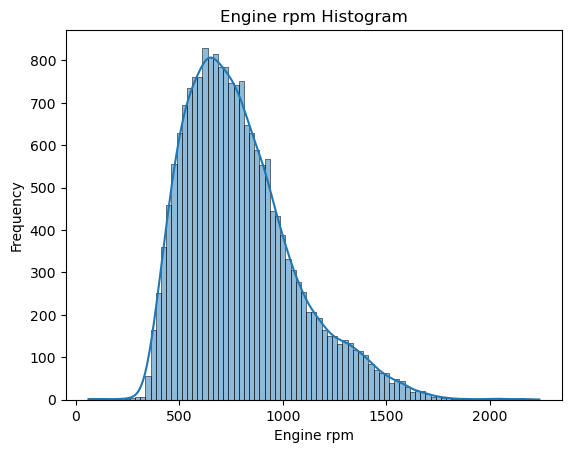

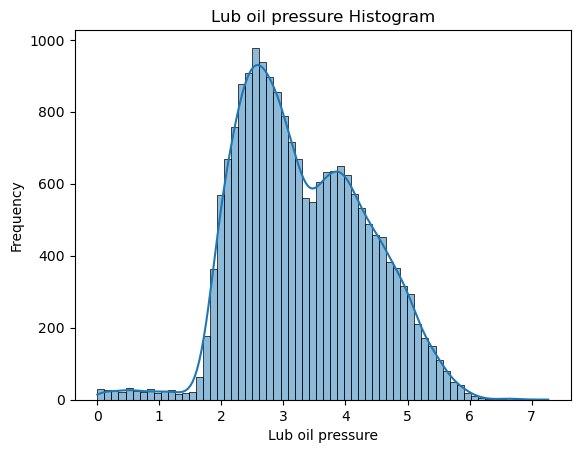

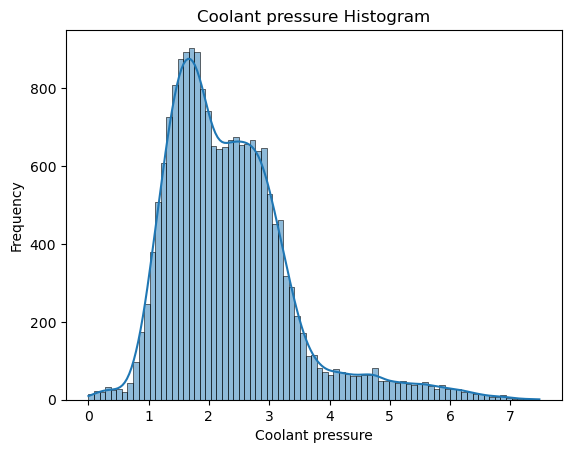

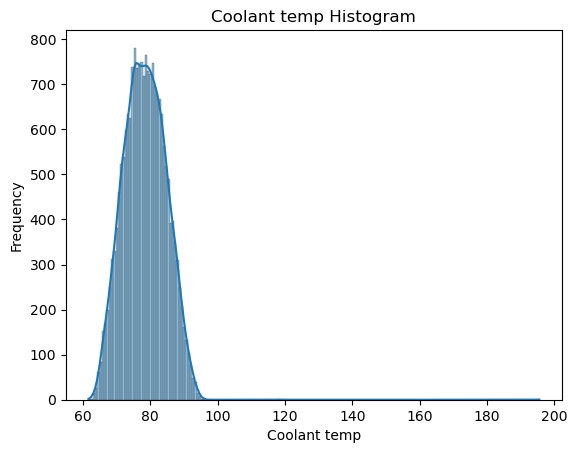

In [199]:
# Inpecting the distribution of each column
for col in df.columns:
    sns.histplot(df[col], kde=True)
    plt.title(f"{col} Histogram")
    plt.xlabel(f"{col}")
    plt.ylabel("Frequency")
    plt.show()

The histograms reveal we are working with non-gaussian distributed data.

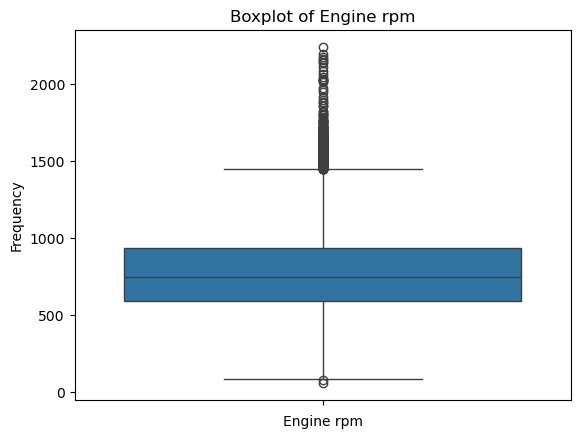

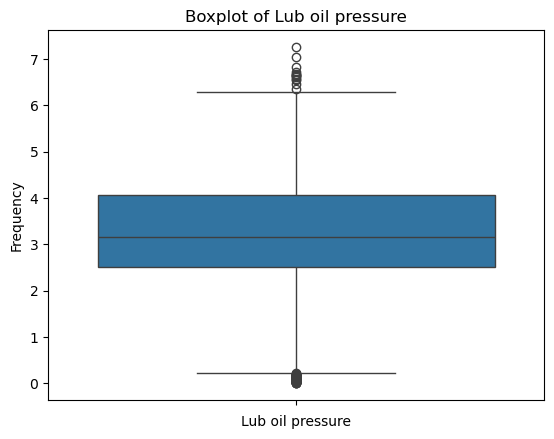

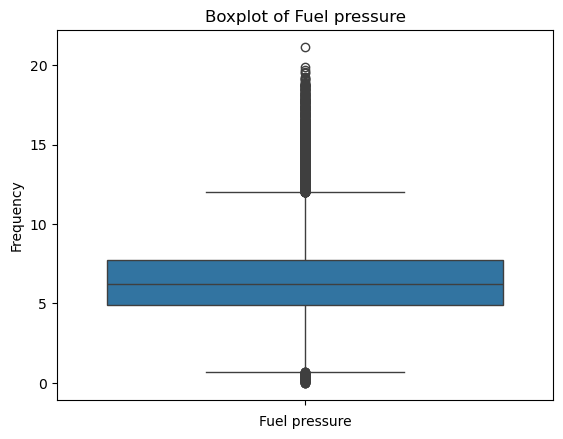

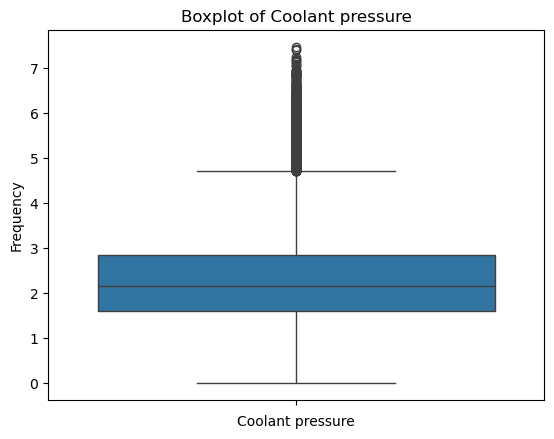

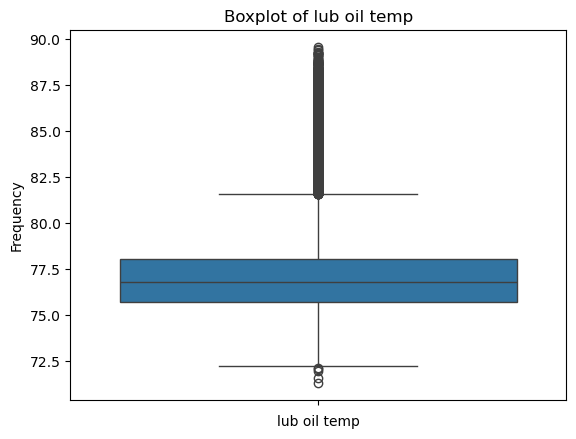

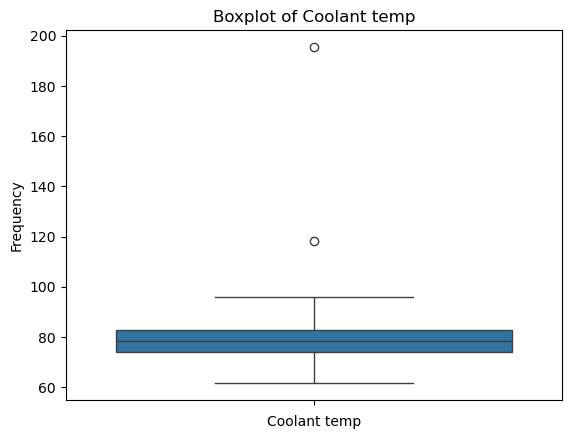

In [200]:
# Boxplots to get a feel for spread and outliers

for col in df.columns:
  sns.boxplot(df[col])
  plt.xlabel(f'{col}')
  plt.ylabel('Frequency')
  plt.title(f'Boxplot of {col}')
  plt.show()

The box plots indicate the presence of outliers in every column, higher and lower than the mean. The density of points seems high for each column with exception of coolant temp, whcih shows only 2 points, both of which are far from the top of the whisker. These two observations could be errors and should be checked with the domain expert.

In [201]:
# Z score analysis

from scipy import stats

z = np.abs(stats.zscore(df))

df_z_in = df[(z < 3).all(axis=1)]
df_z_out = df[(z >= 3).any(axis=1)]

print(df_z_in.shape)
print(df_z_out.shape)


(18337, 6)
(1198, 6)


In [202]:
zscore_3_percentage = 100*df_z_out.shape[0]/df_z_in.shape[0]
print(f'zscore_3_percentage: {zscore_3_percentage:.2f}%')

zscore_3_percentage: 6.53%


Based on analysis of zscore, there are 1198 values with standard deviation of 3 or more, that is 6.53% of the dataset.

In [203]:
# Inspecting values far from the mean, 6 stdev

df_z_extreme = df[(z>=6).any(axis=1)]
print(df_z_extreme.shape)
print(df_z_extreme)

(2, 6)
       Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
3242          760          4.908028       2.594570          1.747730   
10663         455          2.010802       7.806127          1.619575   

       lub oil temp  Coolant temp  
3242      77.873482    118.371957  
10663     76.519385    195.527912  


In [204]:
print(df_z_extreme/df.max())
print(z[3242])
print(z[10663])

       Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
3242     0.339437          0.675519       0.122742          0.233700   
10663    0.203216          0.276758       0.369288          0.216564   

       lub oil temp  Coolant temp  
3242       0.869310      0.605397  
10663      0.854194      1.000000  
[0.11673676 1.5703075  1.47088717 0.56702426 0.07395353 6.43582406]
[ 1.25647909  1.26561457  0.41670874  0.6906834   0.36132086 18.86711876]


Rows 3242 and 10663 seems quite strange. The coolant temp for each are extremely far from the desity of observations, however all other features are within 1.6 standard deviations from the mean. I would consider removing these two rows if training and model on the full dataset. Aditionally will take note of these values to raise to domain expert. It appears these are the two observations noted after plotting the boxplots.

Pair Plot for the Complete Dataframe


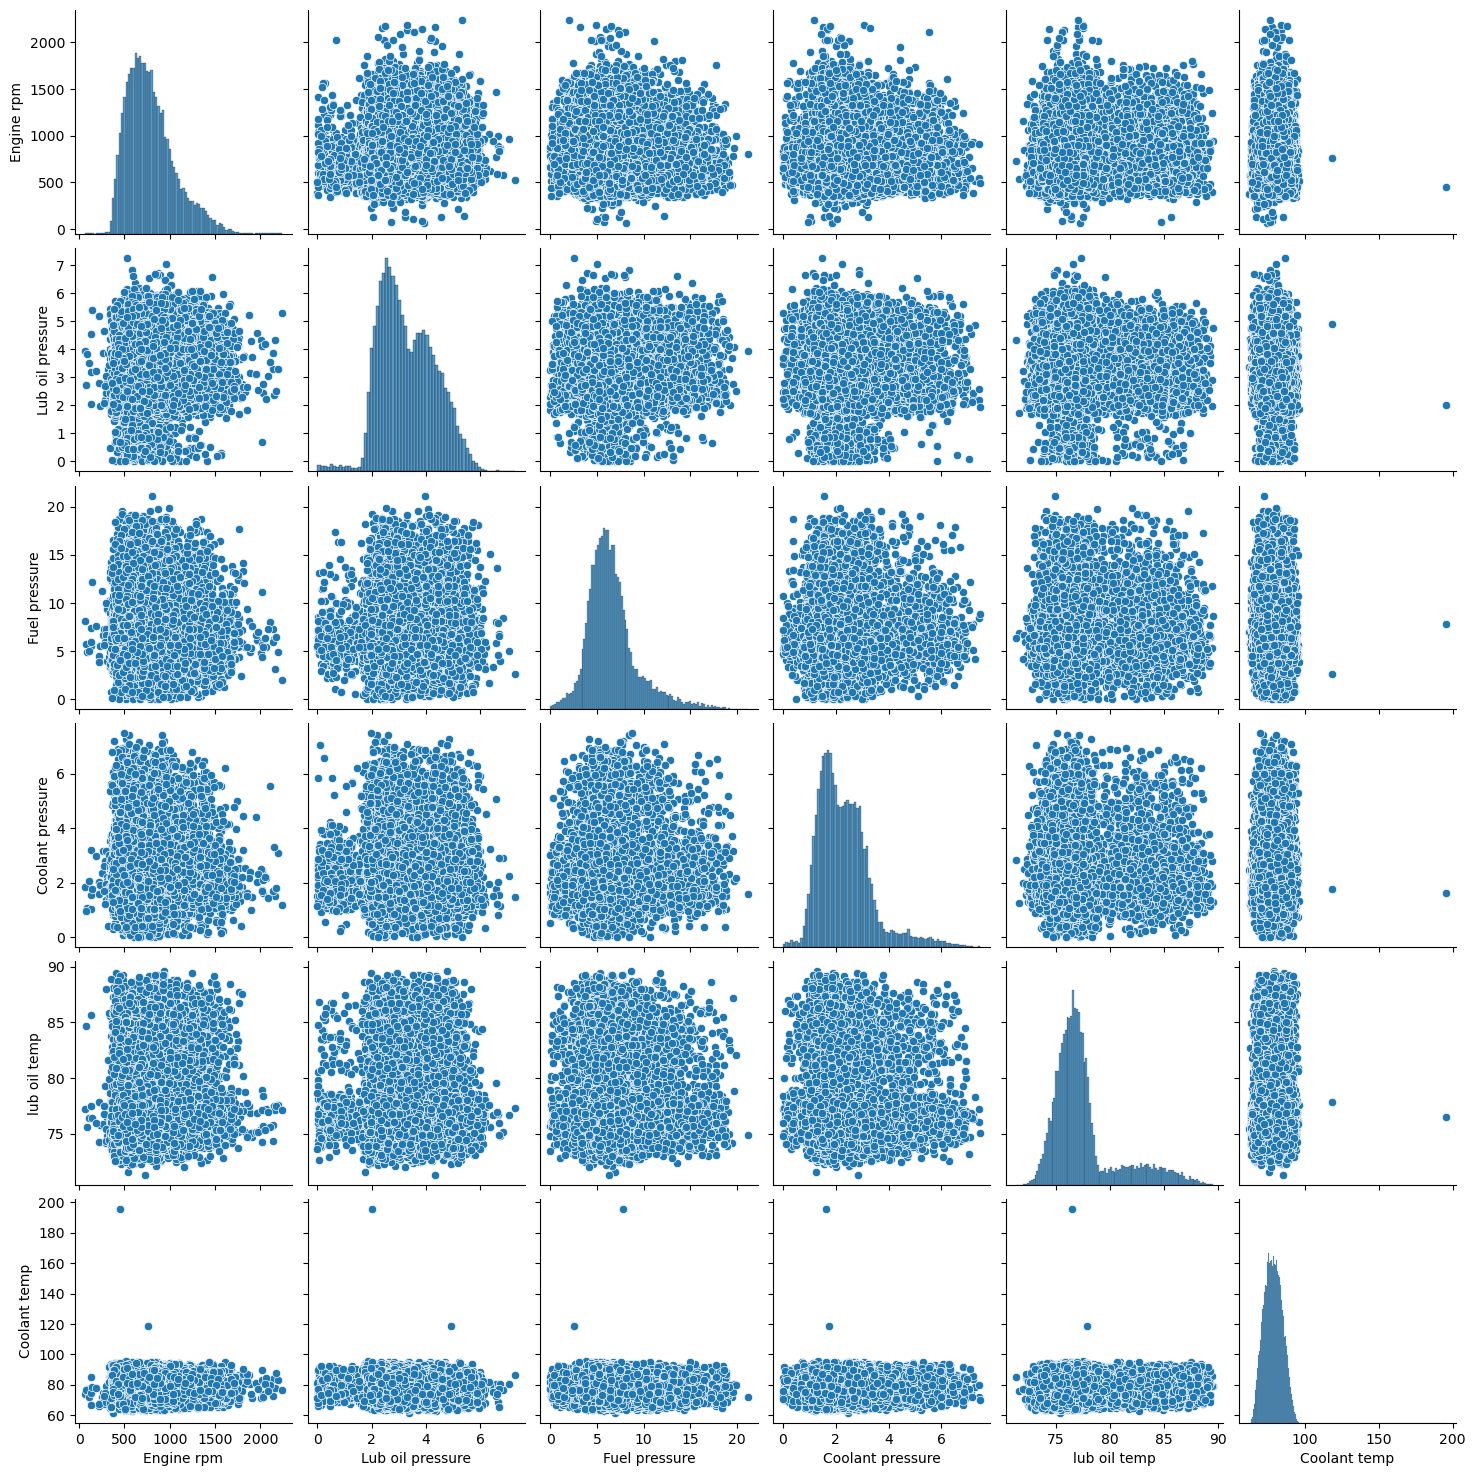

In [205]:
# Inpecting relationships and corrolations between variables

sns.pairplot(df)
print('Pair Plot for the Complete Dataframe')
plt.show()

The scatter plots do not reveal anys strong relationships.

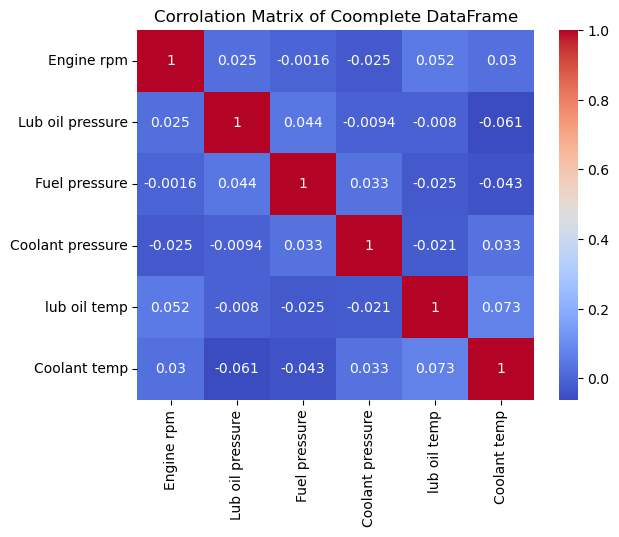

In [206]:
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title('Corrolation Matrix of Coomplete DataFrame')
plt.show()

The corrolation matrix additionally indicates no strong corrolation between variables.

Pair Plot of the Z > 3 DataFrame


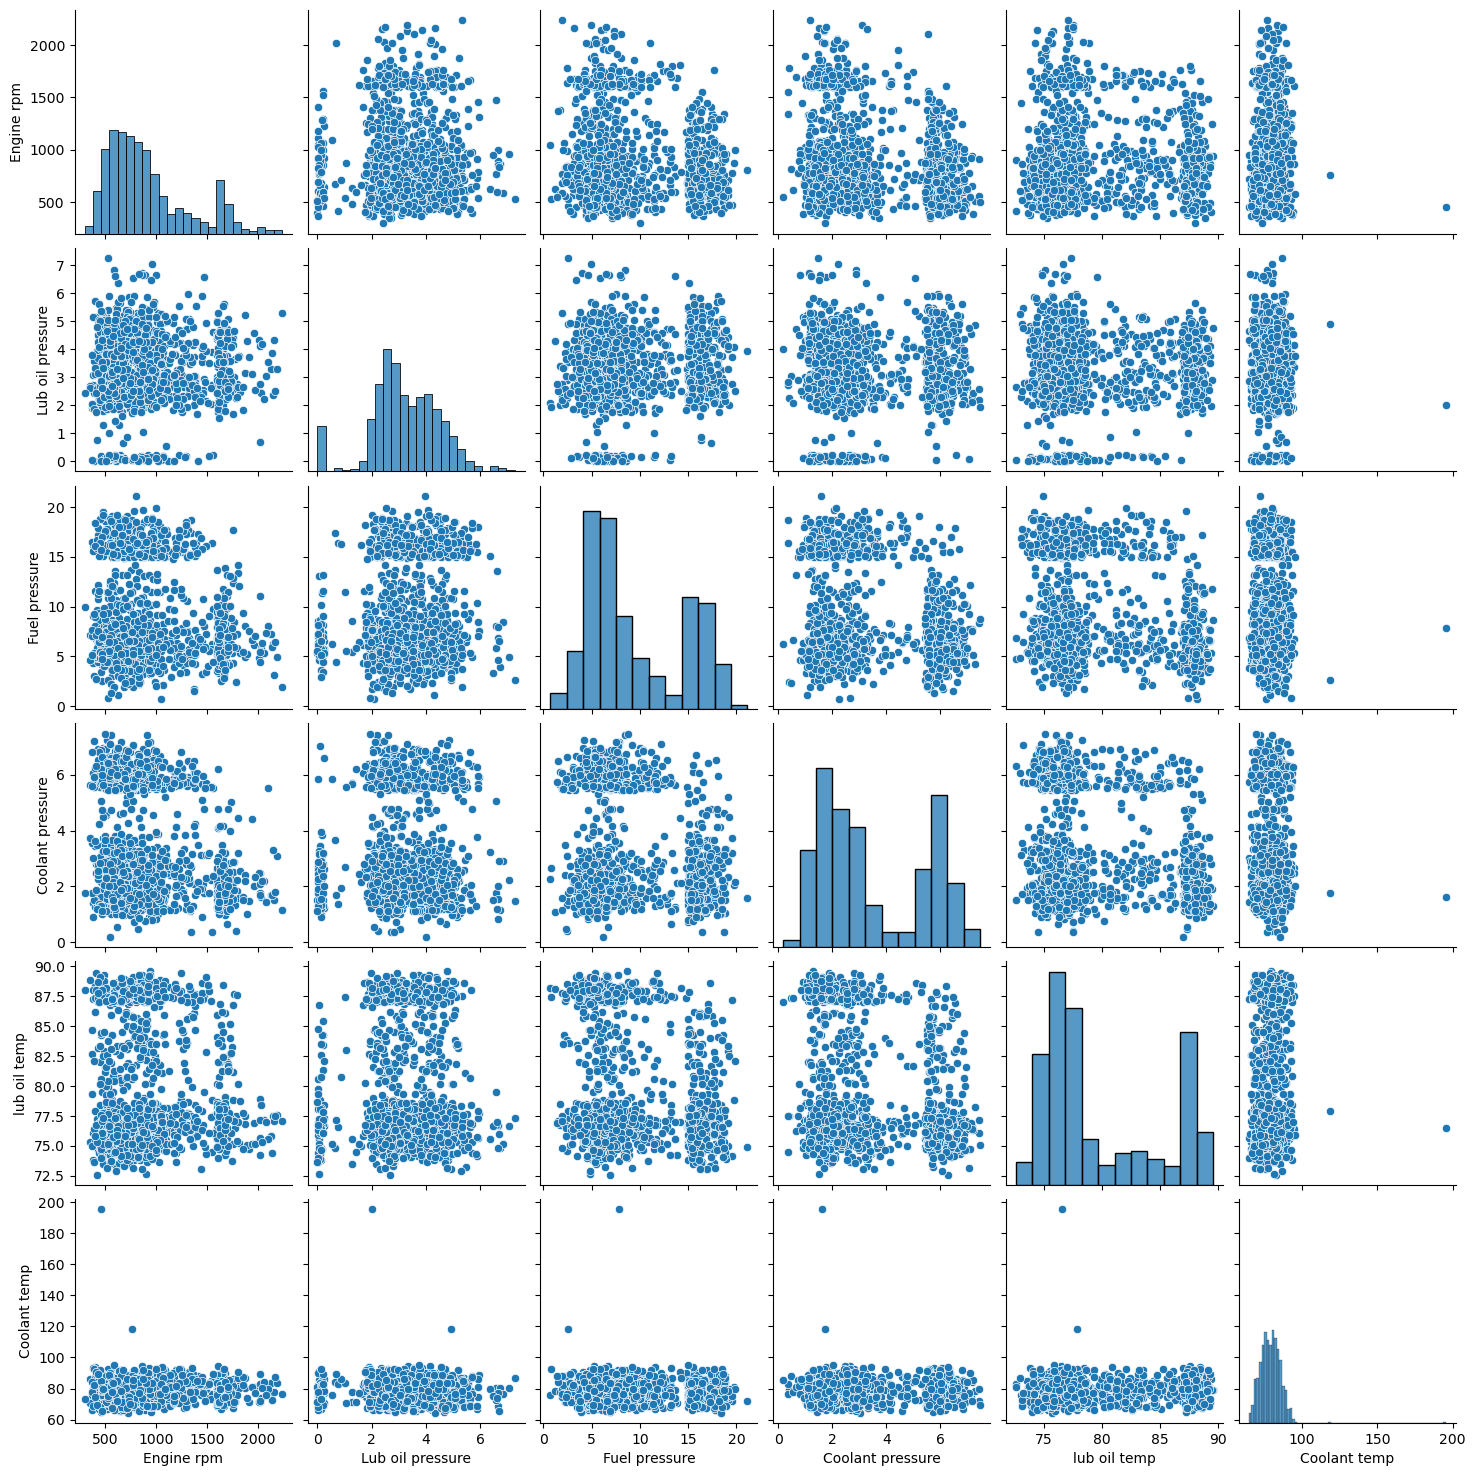

In [207]:
# Investigating relationships between outliers

sns.pairplot(df_z_out)
print('Pair Plot of the Z > 3 DataFrame')
plt.show()

From the pair plot we can see a little structure taking form between variables when looking at the z>3 values.

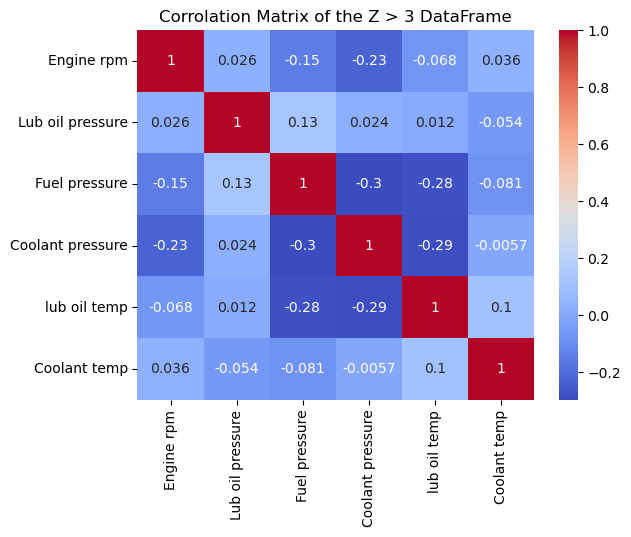

In [208]:
corr_out = df_z_out.corr()
sns.heatmap(corr_out, cmap="coolwarm", annot=True)
plt.title('Corrolation Matrix of the Z > 3 DataFrame')
plt.show()


The corrolation matrix of z>3 observations indicates some relevent corrolation between variables, noteabley 
rpm with coolant pressure
fuel pressure with coolant pressure
fuel pressure with oil temp
coolant pressure with oil temp

all of which are inversely corrolated.

Pair Plot of the Z < 3 DataFrame


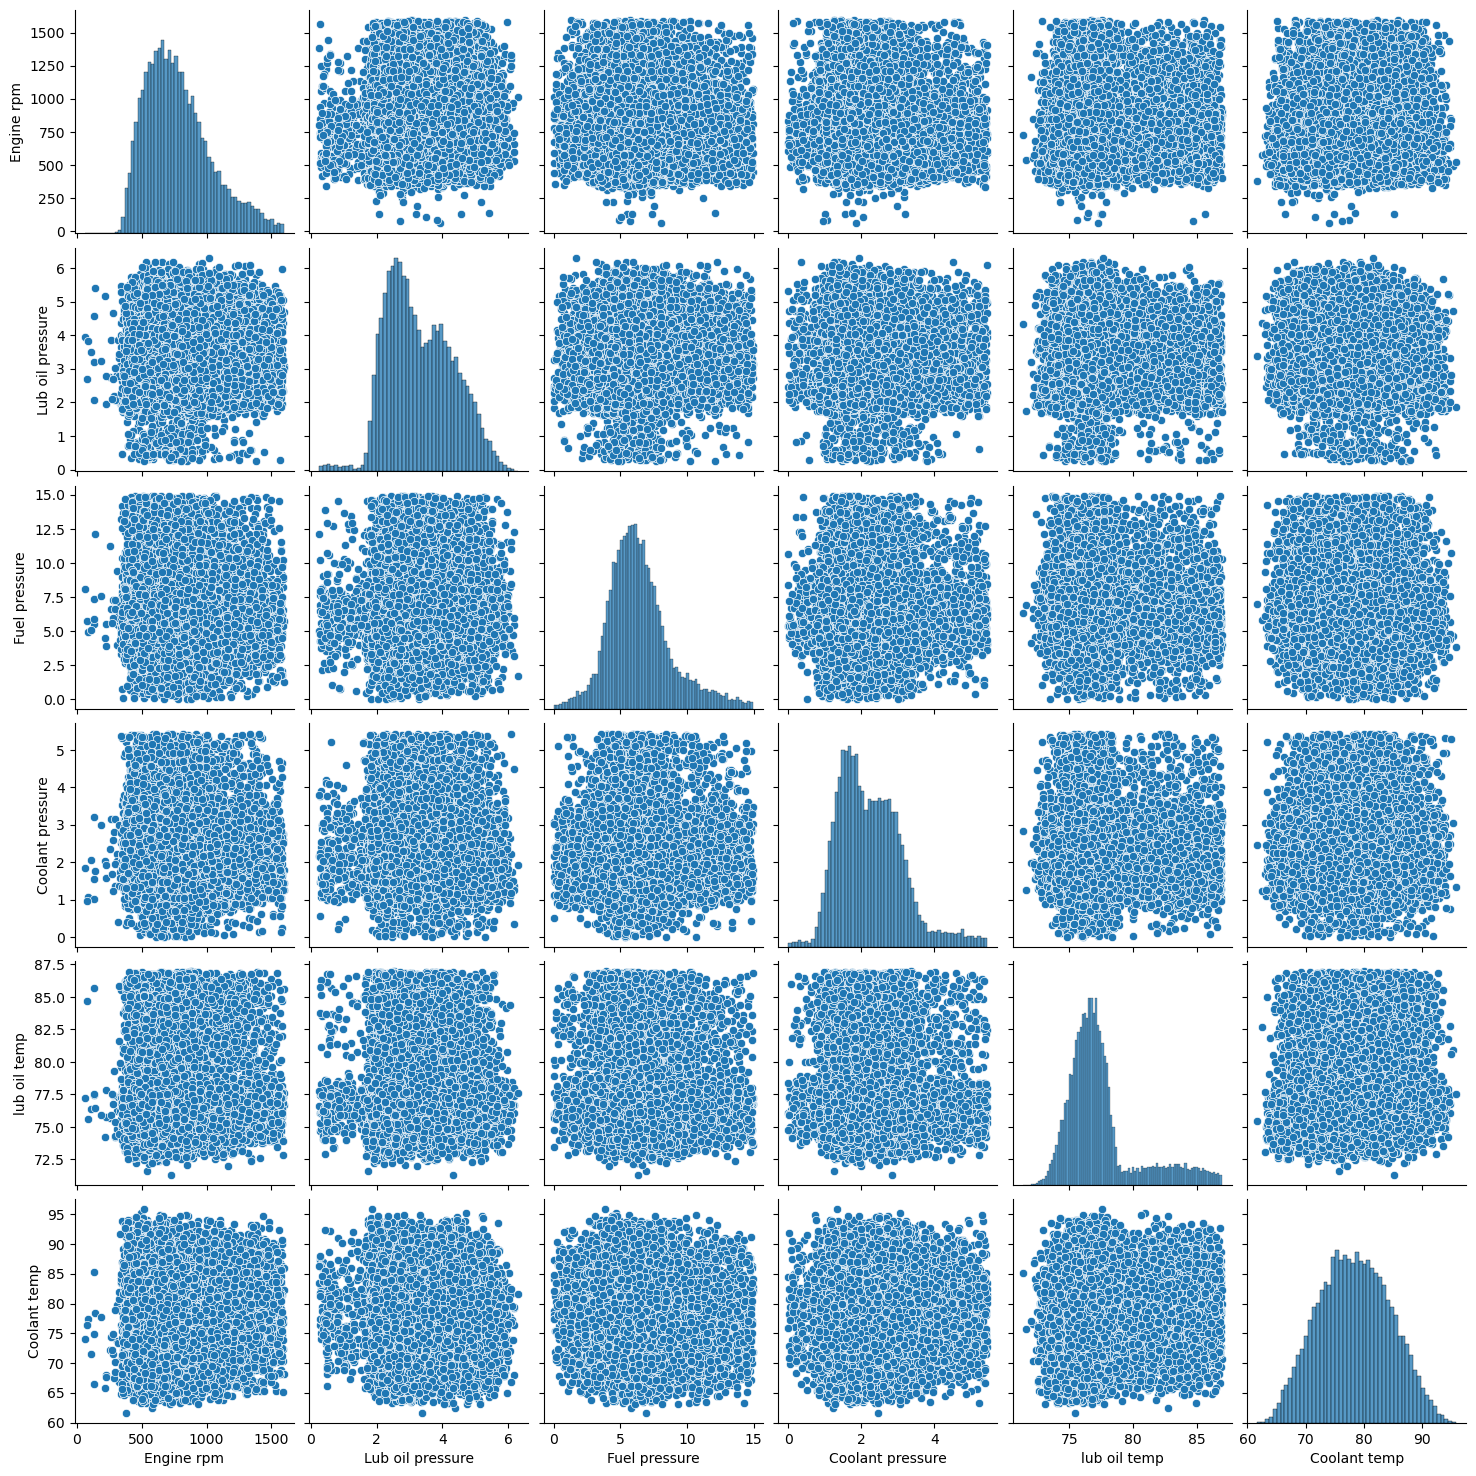

In [209]:
sns.pairplot(df_z_in)
print('Pair Plot of the Z < 3 DataFrame')
plt.show()

Examination of the values within 3 standard devation, we see the distributions tending closer to a normal distribution.

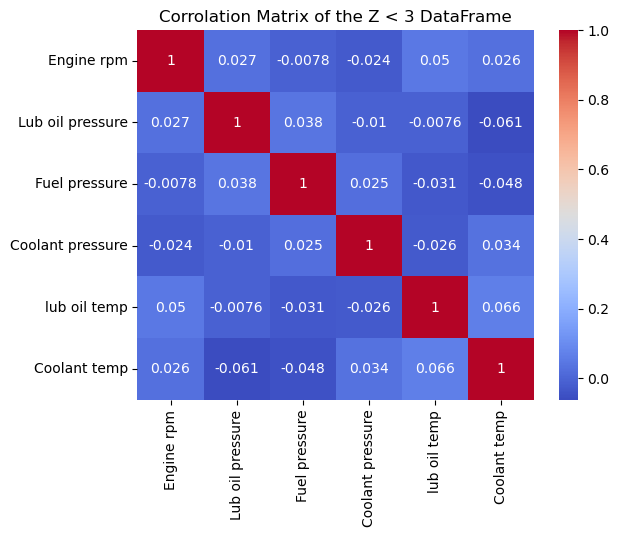

In [210]:
corr_in = df_z_in.corr()
sns.heatmap(corr_in, cmap='coolwarm', annot=True)
plt.title('Corrolation Matrix of the Z < 3 DataFrame')
plt.show()

Now to tidy up some of the variable names and consider some feature creation/selection

In [211]:
# Renaming columns for robust ML processing
df = df.rename(columns={
    "Engine rpm": "engine_rpm",
    "Lub oil pressure": "oil_pressure",
    "Fuel pressure": "fuel_pressure",
    "Coolant pressure": "coolant_pressure",
    "lub oil temp": "oil_temp",
    "Coolant temp": "coolant_temp"
})

In [212]:
# Interquantile range

df = df.copy()

# Filter 5 percent of the tails in any two columns

# Create a dataframe to track extreme values in each row
extreme_count = pd.DataFrame(0, index=df.index, columns=['count'])

# Loop through columns and score each row 
for col in df.columns:
  p025, p975 = df[col].quantile([0.025,0.975])
  df_inner_95 = df[df[col].between(p025,p975)]
  is_extreme = ~df_inner_95[col].between(p025,p975)
  extreme_count['count'] += is_extreme.astype(int)

# Keep rows with fewer than 2 extreme values
df_inner_95 = df_inner_95[extreme_count < 2]

(df_inner_95.shape)
print(f'{100 * (1 - df_inner_95.shape[0]/rows_number)}%')

5.006398771435883%


In [213]:
# Filter using inter quartile range method

# Create a dataframe to track extreme values in each row
df_iqr = df.copy()
df_iqr['count'] = 0

# Loop through each column and score each row
for col in df.columns:
  # Calculate the upper and lower limits.
  q1, q3 = df_iqr[col].quantile([0.25,0.75])
  iqr = q3 - q1
  lower = q1-1.5*iqr
  upper = q3+1.5*iqr
  # Create boolian mask and apply
  mask_outside = ~df_iqr[col].between(lower, upper)
  df_iqr.loc[mask_outside, 'count'] = df_iqr.loc[mask_outside, 'count'] + 1

# IQR results, number of outliers for given boundry
iqr_results = pd.DataFrame(columns=['outlier_boundry', 'outlier_count', 'percentage_of_data'])
for n in range(len(df.columns)):
  mask_outliers = df_iqr['count'] >= n
  outliers = df_iqr.loc[mask_outliers].shape[0]
  perc = 100*outliers/rows_number
  iqr_results.loc[n] = [n, outliers, perc]

iqr_results


outlier_boundry  outlier_count  percentage_of_data
0              0.0        19535.0          100.000000
1              1.0         4636.0           23.731764
2              2.0          422.0            2.160225
3              3.0           11.0            0.056309
4              4.0            0.0            0.000000
5              5.0            0.0            0.000000

We use statistical methods to effectively remove values from the outer quantiles of data. 
The IQR method applyied allows us to filter outliers based on the number of outliers in a given row.
With 2 as the boundy, we filter 2.16% of data.

**Feature Eningeering**

Basic feature engineering, taking into account the physical laws describting relationships between temperature, pressure and viscosity we can create new features by comparing rates of change beetween variables.

In [214]:
# Feature engineering

# Create a copy of the dataframe
df_feature = df.copy()

# Create constants
alpha = 0.04                    #Viscocity constant
epsilon = 1e-6                  #Small number to prevent infinities
T_mean = df['oil_temp'].mean()  #Mean of the oil temperature

# Create dictionary of interactions
interaction_dict = {
  'P_oil/rpm': df["oil_pressure"]/(df["engine_rpm"] + epsilon),
  'P_fuel/rpm': df['fuel_pressure']/(df["engine_rpm"] + epsilon),
  'P_cool/rpm': df['coolant_pressure']/(df["engine_rpm"] + epsilon),
  'T_oil/rpm': df['oil_temp']/(df["engine_rpm"] + epsilon),
  'T_cool/rpm': df['coolant_temp']/(df["engine_rpm"] + epsilon),
  'P_oil/T_oil': df['oil_pressure']/(df['oil_temp'] + epsilon),
  'P_cool/T_cool': df['coolant_pressure']/(df['coolant_temp'] + epsilon),
  'P_oil/P_cool': df['oil_pressure']/(df['coolant_pressure'] + epsilon),
  'T_oil/T_cool': df['oil_temp']/(df['coolant_temp'] + epsilon),
  'Visc_P_oil': df['oil_pressure'] * np.exp(alpha * (df['oil_temp'] - T_mean))
}

for key, val in interaction_dict.items():
    df_feature[key] = val
df_feature.head()

engine_rpm  oil_pressure  fuel_pressure  coolant_pressure   oil_temp  \
0         682      2.391656       4.617196          2.848982  76.272417   
1         605      5.466877       6.424361          5.727520  73.222679   
2         658      3.434232       3.680896          1.678708  88.089916   
3         749      2.094656       7.120927          1.639670  77.661625   
4         676      3.538228       5.956472          3.225336  75.226352   

   coolant_temp  P_oil/rpm  P_fuel/rpm  P_cool/rpm  T_oil/rpm  T_cool/rpm  \
0     69.884609   0.003507    0.006770    0.004177   0.111836    0.102470   
1     74.907314   0.009036    0.010619    0.009467   0.121029    0.123814   
2     78.704806   0.005219    0.005594    0.002551   0.133875    0.119612   
3     82.386700   0.002797    0.009507    0.002189   0.103687    0.109996   
4     67.153220   0.005234    0.008811    0.004771   0.111282    0.099339   

   P_oil/T_oil  P_cool/T_cool  P_oil/P_cool  T_oil/T_cool  Visc_P_oil  
0     0.031357       0.040767      0.839477      1.091405    2.264029  
1     0.074661       0.076461      0.954493      0.977510    4.580819  
2     0.038986       0.021329      2.045758      1.119244    5.215595  
3     0.026972       0.019902      1.277486      0.942648    2.096182  
4     0.047034       0.048030      1.097010      1.120220    3.212159

In [215]:
# Statistical filtering
# Filter 2.5 percent of the tails in any two columns

# Create a dataframe to track extreme values in each row
extreme_count = pd.DataFrame(0, index=df.index, columns=['count'])

# Loop through columns and score each row 
for col in df_feature.columns:
  p025, p975 = df_feature[col].quantile([0.025,0.975])
  df_inner_95 = df_feature[df_feature[col].between(p025,p975)]
  is_extreme = ~df_inner_95[col].between(p025,p975)
  extreme_count['count'] += is_extreme.astype(int)

# Keep rows with fewer than 2 extreme values
df_inner_95 = df_inner_95[extreme_count < 2]

(df_inner_95.shape)
print(100 * (1 - df_inner_95.shape[0]/rows_number))

5.006398771435883


In [216]:
# Filter using inter quartile range method

# Create a dataframe to track extreme values in each row
df_iqr = df_feature.copy()
df_iqr['count'] = 0

# Loop through each column and score each row
for col in df_feature.columns:
  # Calculate the upper and lower limits.
  q1, q3 = df_iqr[col].quantile([0.25,0.75])
  iqr = q3 - q1
  lower = q1-1.5*iqr
  upper = q3+1.5*iqr
  # Create boolian mask and apply
  mask_outside = ~df_iqr[col].between(lower, upper)
  df_iqr.loc[mask_outside, 'count'] = df_iqr.loc[mask_outside, 'count'] + 1

# IQR results, number of outliers for given boundry
iqr_results_feature = pd.DataFrame(columns=['outlier_boundry', 'outlier_count', 'percentage_of_data'])
for n in range(len(df_feature.columns)):
  mask_outliers = df_iqr['count'] >= n
  outliers = df_iqr.loc[mask_outliers].shape[0]
  perc = 100*outliers/rows_number
  iqr_results_feature.loc[n] = [n, outliers, perc]

iqr_results_feature

outlier_boundry  outlier_count  percentage_of_data
0               0.0        19535.0          100.000000
1               1.0         6140.0           31.430765
2               2.0         2222.0           11.374456
3               3.0          877.0            4.489378
4               4.0          226.0            1.156898
5               5.0           88.0            0.450474
6               6.0           24.0            0.122856
7               7.0            5.0            0.025595
8               8.0            1.0            0.005119
9               9.0            0.0            0.000000
10             10.0            0.0            0.000000
11             11.0            0.0            0.000000
12             12.0            0.0            0.000000
13             13.0            0.0            0.000000
14             14.0            0.0            0.000000
15             15.0            0.0            0.000000

Repeating the statistical approach after basic feature engineering our optimum decision boundy increases from 2 to 3, filtering 4.49%

**Feature Discovery**

Let us explore further feature engineering techniques. Considering the system is a ship's engine and the dataset from sensors within parts of the engine system, one would reasonably expect the sesors to be related by physical laws. 

We can employ a model to learn the governing reltionships between variables. We can then make a new set of fetures, ressiduals, that are the difference between true values within the dataset and predicted values based on the discovered equations. The ressiduals can than be used to detect outliers.

We will look for relationships of the following form:


- **$oil_{temp} \propto f(engine_{rpm}, coolant_{pressure})$**
- **$coolant_{temp} \propto f(engine_{rpm}, coolant_{pressure})$**
- **$oil_{pressure} \propto f(oil_{temp})$**
- **$fuel_{pressure} \propto f(engine_{rpm})$**


In [217]:
# Functions to discover
function_dict = {
  'oil_temp' : ['engine_rpm', 'coolant_temp', 'coolant_pressure'],
  'coolant_temp' : ['engine_rpm', 'coolant_pressure', 'oil_temp'],
  'oil_pressure' : ['engine_rpm', 'oil_temp'],
  'fuel_pressure' : ['engine_rpm']
}
functions_found_dict = {}

In [218]:
# Train on the central distribution of data, and only on origional variables
df_core = df.copy()

for col in ['engine_rpm', 'oil_pressure', 'fuel_pressure', 'coolant_pressure', 'oil_temp', 'coolant_temp']:
  q1, q3 = df_core[col].quantile([0.05,0.95])
  df_core = df_core[df_core[col].between(q1, q3)]

In [219]:
!pip install pysr

In [220]:
# Symbolic regression function
from pysr import PySRRegressor

def symbreg(target=str, functions=list, unary_operators=['exp', 'log', 'sqrt']):
  
  X = df_core[variables].to_numpy()
  y = df_core[target].to_numpy()
  
  model = PySRRegressor(
    procs=1,
    niterations=1500,
    populations=12,
    population_size=48,
    binary_operators=['+', '-', '*', '/'],
    unary_operators=unary_operators,
    loss='loss(x, y) = (x - y)^2',
    maxsize=12,
    verbosity=1,
    batching=True,
    batch_size=50
  )
  
  model.fit(X, y)
  
  print(f'{target} found as {model.sympy()}')
  
  return model

    

In [221]:
# For stability of training
import os
os.environ["JULIA_NUM_THREADS"] = "1"

In [222]:
# Discover functions
for target, variables in function_dict.items():
  if target == 'oil_pressure':
    operators=['exp', 'log', 'sqrt']
  else:
    operators=['log', 'sqrt']
  model = symbreg(target, variables, operators)
  functions_found_dict[target] = model

/opt/homebrew/Caskroom/miniforge/base/envs/base_ds/lib/python3.11/site-packages/pysr/sr.py:1036: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/base_ds/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.590e+04
Progress: 2797 / 18000 total iterations (15.539%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           5.607e+00  0.000e+00  y = 77.366
4           5.598e+00  5.353e-04  y = log(x₁) + 73.005
5           5.597e+00  1.410e-04  y = log(sqrt(x₀)) + 74.058
6           5.597e+00  4.339e-05  y = sqrt(sqrt(sqrt(x₀))) + 75.074
7           5.595e+00  2.281e-04  y = sqrt(sqrt(x₀ + 3323.7)) + 69.376
8           5.588e+00  1.253e-03  y = (log(sqrt(x₀)) + log(x₁)) + 69.691
9           5.586e+00  5.032e-04  y = sqrt(sqrt((x₁ * 31.798) + x₀)) + 69.813
11          5.585e+00  2.831e-06  y = sqrt(sqrt((x₀ - x₂) + (x₁ * 31.798))) + 69.813
───────────────────────────────────────────────────────────────────────────────────────────────────
═════════════════════════

[ Info: Final population:
[ Info: Results saved to:
/opt/homebrew/Caskroom/miniforge/base/envs/base_ds/lib/python3.11/site-packages/pysr/sr.py:1036: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/base_ds/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.880e+04
Progress: 3019 / 18000 total iterations (16.772%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.585e+01  0.000e+00  y = 78.393
4           2.581e+01  5.224e-04  y = sqrt(x₂) - -69.598
5           2.581e+01  2.172e-04  y = (x₂ * 0.078087) + 72.354
6           2.581e+01  5.722e-05  y = sqrt(x₂ * 2.704) + 63.918
8           2.580e+01  1.250e-04  y = sqrt((x₁ + x₂) * 1.7935) - -66.468
10          2.580e+01  7.037e-05  y = sqrt((x₁ + (x₂ - -1.5771)) * 2.8674) - -63.129
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluate

[ Info: Final population:
[ Info: Results saved to:
/opt/homebrew/Caskroom/miniforge/base/envs/base_ds/lib/python3.11/site-packages/pysr/sr.py:1036: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/base_ds/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


coolant_temp found as x2*(1.8928798 + x2*(-0.011355412))
  - outputs/20251221_134504_6te4cv/hall_of_fame.csv

Expressions evaluated per second: 2.940e+04
Progress: 2256 / 18000 total iterations (12.533%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.966e-01  0.000e+00  y = 3.2866
6           6.966e-01  9.799e-06  y = sqrt(log(log(x₀)) - -8.9272)
7           6.966e-01  5.841e-06  y = sqrt(log(log(sqrt(x₀))) - -9.6098)
8           6.966e-01  5.007e-06  y = sqrt(log(log(x₀ - x₁)) - -8.9272)
12          6.966e-01  1.460e-06  y = sqrt(sqrt(log(log(log((x₀ * 0.25351) - x₁)))) - -10.12...
                                      )
───────────────────────────────────────────────────────────────────────────────────────────────────
═══════════════════════════════════════════════════════════

[ Info: Final population:
[ Info: Results saved to:
/opt/homebrew/Caskroom/miniforge/base/envs/base_ds/lib/python3.11/site-packages/pysr/sr.py:1036: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/base_ds/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 2.620e+04
Progress: 2063 / 18000 total iterations (11.461%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.674e+00  0.000e+00  y = 6.4764
5           3.674e+00  6.944e-06  y = sqrt(log(x₀) + 35.332)
7           3.674e+00  4.917e-06  y = sqrt(log(x₀ + 70.51) + 35.255)
8           3.674e+00  3.874e-06  y = sqrt(sqrt(sqrt(x₀) / 317.65)) + 5.9341
10          3.674e+00  1.788e-07  y = sqrt(sqrt(sqrt(x₀ + 5.9341) / 317.65)) + 5.9341
12          3.674e+00  1.076e-05  y = sqrt((sqrt(sqrt(x₀)) + 35.214) + ((x₀ + 317.65) / x₀))
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to

[ Info: Final population:
[ Info: Results saved to:


fuel_pressure found as x0*(sqrt(x0/(x0 - 12.537544)) - 0.9998275)
  - outputs/20251221_134612_P3x0Ya/hall_of_fame.csv


In [223]:
# Make predictions using the discovered equations, calculate ressiduals, add ressidual as new feature
df_fe = df_feature.copy()
predications_dict = {}
error_dict = {}

for (target, variables), (target_name, model) in zip(function_dict.items(), functions_found_dict.items()):
  X = df_fe[variables].values
  Y = df_fe[target].values
  y_pred = model.predict(X)
  predications_dict[target_name] = y_pred
  df_fe[f'SR_residual_{target_name}'] = Y - y_pred
  df_fe[f'SR_abs_resid_{target_name}'] = np.abs(df_fe[f'SR_residual_{target_name}'])

In [224]:
df_fe.head()

engine_rpm  oil_pressure  fuel_pressure  coolant_pressure   oil_temp  \
0         682      2.391656       4.617196          2.848982  76.272417   
1         605      5.466877       6.424361          5.727520  73.222679   
2         658      3.434232       3.680896          1.678708  88.089916   
3         749      2.094656       7.120927          1.639670  77.661625   
4         676      3.538228       5.956472          3.225336  75.226352   

   coolant_temp  P_oil/rpm  P_fuel/rpm  P_cool/rpm  T_oil/rpm  ...  \
0     69.884609   0.003507    0.006770    0.004177   0.111836  ...   
1     74.907314   0.009036    0.010619    0.009467   0.121029  ...   
2     78.704806   0.005219    0.005594    0.002551   0.133875  ...   
3     82.386700   0.002797    0.009507    0.002189   0.103687  ...   
4     67.153220   0.005234    0.008811    0.004771   0.111282  ...   

   T_oil/T_cool  Visc_P_oil  SR_residual_oil_temp  SR_abs_resid_oil_temp  \
0      1.091405    2.264029             -0.938528               0.938528   
1      0.977510    4.580819             -3.997770               3.997770   
2      1.119244    5.215595             10.778025              10.778025   
3      0.942648    2.096182              0.239248               0.239248   
4      1.120220    3.212159             -1.940306               1.940306   

   SR_residual_coolant_temp  SR_abs_resid_coolant_temp  \
0                 -8.430008                   8.430008   
1                 -2.811685                   2.811685   
2                  0.077287                   0.077287   
3                  3.870793                   3.870793   
4                -10.980900                  10.980900   

   SR_residual_oil_pressure  SR_abs_resid_oil_pressure  \
0                 -0.898498                   0.898498   
1                  2.166641                   2.166641   
2                  0.183144                   0.183144   
3                 -1.190905                   1.190905   
4                  0.244616                   0.244616   

   SR_residual_fuel_pressure  SR_abs_resid_fuel_pressure  
0                  -1.856998                    1.856998  
1                  -0.047919                    0.047919  
2                  -2.792411                    2.792411  
3                   0.643138                    0.643138  
4                  -0.517478                    0.517478  

[5 rows x 24 columns]

In [225]:
functions_found_dict

{'oil_temp': PySRRegressor.equations_ = [
 	   pick     score                                           equation  \
 	0        0.000000                                           77.36617   
 	1        0.000536                                 log(x1) + 73.00581   
 	2        0.000141                           log(sqrt(x0)) + 74.05831   
 	3        0.000165                    sqrt(x0 / 956.8282) + 76.458435   
 	4  >>>>  0.001367                     log(sqrt(x0) * x1) + 69.701584   
 	5        0.000002               (log(sqrt(x0)) + log(x1)) + 69.69803   
 	6        0.000529       sqrt(sqrt((x1 * 35.056072) + x0)) + 69.66732   
 	7        0.000074  sqrt(sqrt(x0 + ((x1 - x2) * 35.960514))) + 69....   
 	8        0.000016  sqrt(sqrt((x1 * (35.960514 - log(x2))) + x0)) ...   
 	
 	       loss  complexity  
 	0  5.606655           1  
 	1  5.597653           4  
 	2  5.596863           5  
 	3  5.595939           6  
 	4  5.588293           7  
 	5  5.588281           8  
 	6  5.585326      

Now let us reapply statistical filtering with the new features included.

In [226]:
# Reaplying statistical filtering with the new features included

# Filter 5 percent of the tails in any two columns
# Create a dataframe to track extreme values in each row
extreme_count = pd.DataFrame(0, index=df_fe.index, columns=['count'])

# Loop through columns and score each row 
for col in df_fe.columns:
  p025, p975 = df_fe[col].quantile([0.025,0.975])
  df_inner_95 = df_fe[df_fe[col].between(p025,p975)]
  is_extreme = ~df_inner_95[col].between(p025,p975)
  extreme_count['count'] += is_extreme.astype(int)

# Keep rows with fewer than 2 extreme values
df_inner_95_fe = df_inner_95[extreme_count < 2]

(df_inner_95_fe.shape)
print(100 * (1 - df_inner_95_fe.shape[0]/rows_number))

5.006398771435883


In [227]:
# Filter using inter quartile range method

# Create a dataframe to track extreme values in each row
df_iqr = df_fe.copy()
df_iqr['count'] = 0

# Loop through each column and score each row
for col in df_fe.columns:
  # Calculate the upper and lower limits.
  q1, q3 = df_iqr[col].quantile([0.25,0.75])
  iqr = q3 - q1
  lower = q1-1.5*iqr
  upper = q3+1.5*iqr
  # Create boolian mask and apply
  mask_outside = ~df_iqr[col].between(lower, upper)
  df_iqr.loc[mask_outside, 'count'] = df_iqr.loc[mask_outside, 'count'] + 1

# IQR results, number of outliers for given boundry
iqr_results_fe = pd.DataFrame(columns=['outlier_boundry', 'outlier_count', 'percentage_of_data'])
for n in range(len(df_fe.columns)):
  mask_outliers = df_iqr['count'] >= n
  outliers = df_iqr.loc[mask_outliers].shape[0]
  perc = 100*outliers/rows_number
  iqr_results_fe.loc[n] = [n, outliers, perc]

iqr_results_fe

outlier_boundry  outlier_count  percentage_of_data
0               0.0        19535.0          100.000000
1               1.0         6455.0           33.043256
2               2.0         4622.0           23.660097
3               3.0         3472.0           17.773228
4               4.0         1317.0            6.741746
5               5.0          543.0            2.779626
6               6.0          266.0            1.361659
7               7.0          120.0            0.614282
8               8.0           42.0            0.214999
9               9.0           14.0            0.071666
10             10.0            4.0            0.020476
11             11.0            1.0            0.005119
12             12.0            0.0            0.000000
13             13.0            0.0            0.000000
14             14.0            0.0            0.000000
15             15.0            0.0            0.000000
16             16.0            0.0            0.000000
17             17.0            0.0            0.000000
18             18.0            0.0            0.000000
19             19.0            0.0            0.000000
20             20.0            0.0            0.000000
21             21.0            0.0            0.000000
22             22.0            0.0            0.000000
23             23.0            0.0            0.000000

With full feature engineering regime applied, the boundry increases to 5, filtering 2.8% of data.

Let us now apply some machine learning techniques to each feature set.

In [228]:
df = df.copy()        # Origional feature set
df_feature = df_feature.copy()  # Ratio engineered set
df_symbolic = df_fe.copy()  # Ratio and Ressidual set


In [229]:
print(f'{df.head()}\n')

   engine_rpm  oil_pressure  fuel_pressure  coolant_pressure   oil_temp  \
0         682      2.391656       4.617196          2.848982  76.272417   
1         605      5.466877       6.424361          5.727520  73.222679   
2         658      3.434232       3.680896          1.678708  88.089916   
3         749      2.094656       7.120927          1.639670  77.661625   
4         676      3.538228       5.956472          3.225336  75.226352   

   coolant_temp  
0     69.884609  
1     74.907314  
2     78.704806  
3     82.386700  
4     67.153220  



In [230]:
print(f'{df_feature.head()}\n')

   engine_rpm  oil_pressure  fuel_pressure  coolant_pressure   oil_temp  \
0         682      2.391656       4.617196          2.848982  76.272417   
1         605      5.466877       6.424361          5.727520  73.222679   
2         658      3.434232       3.680896          1.678708  88.089916   
3         749      2.094656       7.120927          1.639670  77.661625   
4         676      3.538228       5.956472          3.225336  75.226352   

   coolant_temp  P_oil/rpm  P_fuel/rpm  P_cool/rpm  T_oil/rpm  T_cool/rpm  \
0     69.884609   0.003507    0.006770    0.004177   0.111836    0.102470   
1     74.907314   0.009036    0.010619    0.009467   0.121029    0.123814   
2     78.704806   0.005219    0.005594    0.002551   0.133875    0.119612   
3     82.386700   0.002797    0.009507    0.002189   0.103687    0.109996   
4     67.153220   0.005234    0.008811    0.004771   0.111282    0.099339   

   P_oil/T_oil  P_cool/T_cool  P_oil/P_cool  T_oil/T_cool  Visc_P_oil  
0     0.031357

In [231]:
print(f'{df_symbolic.head()}\n')

   engine_rpm  oil_pressure  fuel_pressure  coolant_pressure   oil_temp  \
0         682      2.391656       4.617196          2.848982  76.272417   
1         605      5.466877       6.424361          5.727520  73.222679   
2         658      3.434232       3.680896          1.678708  88.089916   
3         749      2.094656       7.120927          1.639670  77.661625   
4         676      3.538228       5.956472          3.225336  75.226352   

   coolant_temp  P_oil/rpm  P_fuel/rpm  P_cool/rpm  T_oil/rpm  ...  \
0     69.884609   0.003507    0.006770    0.004177   0.111836  ...   
1     74.907314   0.009036    0.010619    0.009467   0.121029  ...   
2     78.704806   0.005219    0.005594    0.002551   0.133875  ...   
3     82.386700   0.002797    0.009507    0.002189   0.103687  ...   
4     67.153220   0.005234    0.008811    0.004771   0.111282  ...   

   T_oil/T_cool  Visc_P_oil  SR_residual_oil_temp  SR_abs_resid_oil_temp  \
0      1.091405    2.264029             -0.938528   

**Feature Selection**

In [232]:
# VIF analysis of dataframe
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

vif_df = pd.DataFrame()
vif_df['variables'] = df.columns
vif_df['VIF'] = [vif(df.values, i) for i in range(len(df.columns))]
print(vif_df.sort_values(by='VIF', ascending=True))

          variables         VIF
3  coolant_pressure    6.056369
2     fuel_pressure    6.754031
0        engine_rpm    9.766473
1      oil_pressure   11.298999
5      coolant_temp  137.068210
4          oil_temp  157.311236


Although there is large coliniarity within the last two variables, lets keep the origional feature set as is for comparison.

In [234]:
# VIF analysis of ratios dataframe
vif_df_feature = pd.DataFrame()
vif_df_feature['variables'] = df_feature.columns
vif_df_feature['VIF'] = [vif(df_feature.values, i) for i in range(len(df_feature.columns))]
print(vif_df_feature.sort_values(by='VIF', ascending=True))

           variables           VIF
13      P_oil/P_cool      1.020376
0         engine_rpm     40.848643
8         P_cool/rpm     58.857118
2      fuel_pressure     67.382054
7         P_fuel/rpm     68.863991
6          P_oil/rpm    107.717295
12     P_cool/T_cool    980.342506
3   coolant_pressure   1010.653011
10        T_cool/rpm   1323.966543
9          T_oil/rpm   1363.785539
15        Visc_P_oil   3677.126936
14      T_oil/T_cool   4947.514642
5       coolant_temp   5723.695039
4           oil_temp  18850.399202
11       P_oil/T_oil  47564.974928
1       oil_pressure  75865.609009


There is a huge amount of covariance with this feature set, as to be expected with feature creation using ratios of other features.
For now let us only drop the high colinear columns from the origional features.

In [236]:
df_feature_reduced = df_feature.copy().drop(['coolant_temp', 'oil_temp'], axis=1)
df_feature_reduced.head()

engine_rpm  oil_pressure  fuel_pressure  coolant_pressure  P_oil/rpm  \
0         682      2.391656       4.617196          2.848982   0.003507   
1         605      5.466877       6.424361          5.727520   0.009036   
2         658      3.434232       3.680896          1.678708   0.005219   
3         749      2.094656       7.120927          1.639670   0.002797   
4         676      3.538228       5.956472          3.225336   0.005234   

   P_fuel/rpm  P_cool/rpm  T_oil/rpm  T_cool/rpm  P_oil/T_oil  P_cool/T_cool  \
0    0.006770    0.004177   0.111836    0.102470     0.031357       0.040767   
1    0.010619    0.009467   0.121029    0.123814     0.074661       0.076461   
2    0.005594    0.002551   0.133875    0.119612     0.038986       0.021329   
3    0.009507    0.002189   0.103687    0.109996     0.026972       0.019902   
4    0.008811    0.004771   0.111282    0.099339     0.047034       0.048030   

   P_oil/P_cool  T_oil/T_cool  Visc_P_oil  
0      0.839477      1.091405    2.264029  
1      0.954493      0.977510    4.580819  
2      2.045758      1.119244    5.215595  
3      1.277486      0.942648    2.096182  
4      1.097010      1.120220    3.212159

In [237]:
# VIF analysis of ratios + ressiduals dataframe
vif_df_symbolic = pd.DataFrame()
vif_df_symbolic['variables'] = df_symbolic.columns
vif_df_symbolic['VIF'] = [vif(df_symbolic.values, i) for i in range(len(df_symbolic.columns))]
print(vif_df_symbolic.sort_values(by='VIF', ascending=True))

                     variables           VIF
13                P_oil/P_cool  1.007743e+00
21   SR_abs_resid_oil_pressure  1.038456e+00
23  SR_abs_resid_fuel_pressure  1.350940e+00
19   SR_abs_resid_coolant_temp  2.942943e+00
17       SR_abs_resid_oil_temp  9.407614e+00
8                   P_cool/rpm  1.571230e+01
7                   P_fuel/rpm  1.675768e+01
6                    P_oil/rpm  2.094641e+01
12               P_cool/T_cool  1.646105e+02
3             coolant_pressure  1.669836e+02
10                  T_cool/rpm  1.790644e+02
14                T_oil/T_cool  2.259892e+02
9                    T_oil/rpm  5.761600e+02
0                   engine_rpm  1.030630e+03
15                  Visc_P_oil  4.369114e+03
18    SR_residual_coolant_temp  3.315117e+04
5                 coolant_temp  3.335544e+04
11                 P_oil/T_oil  4.794024e+04
16        SR_residual_oil_temp  5.726715e+04
20    SR_residual_oil_pressure  2.953123e+06
22   SR_residual_fuel_pressure  4.040855e+06
2         

Based on the VIF analysis there is a high amount of colinearity pressent within the feature engineered dataframe, as to be expected since we dervided relationships from a few initial variables. keeping the following variables due to low VIF score:

SR_abs_resid_oil_temp        (thermal violation)
SR_abs_resid_coolant_temp    (cooling failure signal)
SR_abs_resid_oil_pressure    (lubrication anomaly)
SR_abs_resid_fuel_pressure   (fuel regulation anomaly)

P_oil/P_cool                 (pressure balance indicator)

and the following two variables based on the initial data exploration (scatter and corrolation plots):

engine_rpm                  (operating regime)
coolant_pressure            (cooling system state)

In [238]:
df_symbolic_reduced = df_symbolic[['engine_rpm', 'coolant_pressure', 'SR_abs_resid_oil_temp', 'SR_abs_resid_coolant_temp', 'SR_abs_resid_oil_pressure', 'SR_abs_resid_fuel_pressure', 'P_oil/P_cool']]

In [241]:
# VIF re-analysis
vif_df_reduced = pd.DataFrame()
vif_df_reduced['variables'] = df_feature_reduced.columns
vif_df_reduced['VIF'] = [vif(df_feature_reduced, i) for i in range(len(df_feature_reduced.columns))]
print(vif_df_reduced.sort_values(by='VIF', ascending=True))

           variables           VIF
11      P_oil/P_cool      1.020284
0         engine_rpm     37.002692
6         P_cool/rpm     57.501611
2      fuel_pressure     66.065544
5         P_fuel/rpm     67.618574
4          P_oil/rpm    104.229916
12      T_oil/T_cool    243.294449
8         T_cool/rpm    546.511216
3   coolant_pressure    642.007288
10     P_cool/T_cool    653.369912
7          T_oil/rpm    840.867365
13        Visc_P_oil   3602.863933
9        P_oil/T_oil  46571.087770
1       oil_pressure  75313.658615


In [242]:
vif_df_symbolic_reduced = pd.DataFrame()
vif_df_symbolic_reduced['variables'] = df_symbolic_reduced.columns
vif_df_symbolic_reduced['VIF'] = [vif(df_symbolic_reduced, i) for i in range(len(df_symbolic_reduced.columns))]
print(vif_df_symbolic_reduced)

                    variables       VIF
0                  engine_rpm  5.605264
1            coolant_pressure  4.575634
2       SR_abs_resid_oil_temp  1.835916
3   SR_abs_resid_coolant_temp  2.716898
4   SR_abs_resid_oil_pressure  2.870806
5  SR_abs_resid_fuel_pressure  1.967825
6                P_oil/P_cool  1.015012


**Data Scaling and Pre-Processing**

Now with 3 data frames to compare, lets prepare them for training OCSVM and Iso Forest models

In [243]:
# Columns
df_columns = df.columns
print(df_columns)

df_feature_reduced_columns = df_feature_reduced.columns
print(df_feature_reduced_columns)

df_symbolic_reduced_columns = df_symbolic_reduced.columns
print(df_symbolic_reduced_columns)

Index(['engine_rpm', 'oil_pressure', 'fuel_pressure', 'coolant_pressure',
       'oil_temp', 'coolant_temp'],
      dtype='object')
Index(['engine_rpm', 'oil_pressure', 'fuel_pressure', 'coolant_pressure',
       'P_oil/rpm', 'P_fuel/rpm', 'P_cool/rpm', 'T_oil/rpm', 'T_cool/rpm',
       'P_oil/T_oil', 'P_cool/T_cool', 'P_oil/P_cool', 'T_oil/T_cool',
       'Visc_P_oil'],
      dtype='object')
Index(['engine_rpm', 'coolant_pressure', 'SR_abs_resid_oil_temp',
       'SR_abs_resid_coolant_temp', 'SR_abs_resid_oil_pressure',
       'SR_abs_resid_fuel_pressure', 'P_oil/P_cool'],
      dtype='object')


In [255]:
# Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df = df.copy()
df_feature_reduced = df_feature_reduced.copy()
df_symbolic_reduced = df_symbolic_reduced.copy()

X = df.values
X_f_r = df_feature_reduced.values
X_sy_r = df_symbolic_reduced.values
X_scaled = scaler.fit_transform(X)
X_f_r_scaled = scaler.fit_transform(X_f_r)
X_sy_r_scaled = scaler.fit_transform(X_sy_r)

# Ceate a library of X related data
X_lib = {
  'X': [X, X_scaled, df_columns], 
  'X_feature_reduced': [X_f_r, X_f_r_scaled, df_feature_reduced_columns],
  'X_symbolic_reduced': [X_sy_r, X_sy_r_scaled, df_symbolic_reduced_columns],
}

# Create prediction library
y_pred_lib = {}
'''y_pred_lib = {
  'y' : [y_pred, scores, df_anomaly],
  'y_reduced' : [y_f_r_pred, scores_f_r, df_anomaly_f_r],
  'y_reduced_featured' : [y_sy_r_pred, scores_sy_r, df_anomaly_sy_r]
}'''



"y_pred_lib = {\n  'y' : [y_pred, scores, df_anomaly],\n  'y_reduced' : [y_f_r_pred, scores_f_r, df_anomaly_f_r],\n  'y_reduced_featured' : [y_sy_r_pred, scores_sy_r, df_anomaly_sy_r]\n}"

In [256]:
# One Class Support Vector Machine
from sklearn.svm import OneClassSVM
from sklearn.base import clone
model = OneClassSVM(kernel='rbf', gamma=0.5, nu=0.05)
models = {}

for key, x in X_lib.items():
  m = clone(model)
  m.fit(x[1])
  models[key] = m
  y_pred = m.predict(x[1])
  scores = m.decision_function(x[1])
  print(f'Predictions for {key}, {y_pred}')
  df_anom = pd.DataFrame(x[1], columns = x[2])
  df_anom['anomaly'] = y_pred
  y_pred_lib[key] = [y_pred, scores, df_anom]


Predictions for X, [ 1 -1  1 ...  1  1  1]
Predictions for X_feature_reduced, [1 1 1 ... 1 1 1]
Predictions for X_symbolic_reduced, [ 1 -1  1 ...  1  1  1]


In [258]:
y_pred_lib['X']

[array([ 1, -1,  1, ...,  1,  1,  1]),
 array([ 1.27277103, -0.10156792,  1.03987053, ...,  1.23074544,
         0.64606946,  0.71513058]),
        engine_rpm  oil_pressure  fuel_pressure  coolant_pressure  oil_temp  \
 0       -0.408212     -0.892819      -0.738304          0.495596 -0.440709   
 1       -0.695950      2.117332      -0.083759          3.273154 -1.421047   
 2       -0.497896      0.127697      -1.077426         -0.633625  3.358026   
 3       -0.157842     -1.183534       0.168533         -0.671293  0.005852   
 4       -0.430633      0.229492      -0.253226          0.858747 -0.776966   
 ...           ...           ...            ...               ...       ...   
 19530   -0.411949      0.288774       0.233701         -1.208058 -0.461752   
 19531   -0.789372     -1.038290      -0.511826         -0.833709 -0.243824   
 19532   -0.654845      0.006141      -1.038745          3.537070 -0.563698   
 19533    1.389218     -0.559945      -1.069205          0.594695 -0.2

In [48]:
model = OneClassSVM(kernel='rbf', gamma=0.5, nu=0.05)
model.fit(X_r_scaled)

y_r_pred = model.predict(X_r_scaled)
scores_r = model.decision_function(X_r_scaled)
print(y_r_pred)
df_r_anom = pd.DataFrame(X_r_scaled, columns = df_reduced.columns)
df_r_anom['anomaly'] = y_r_pred

[1 1 1 ... 1 1 1]


In [49]:
model = OneClassSVM(kernel='rbf', gamma=0.5, nu=0.05)
model.fit(X_r_fe_scaled)

y_r_fe_pred = model.predict(X_r_fe_scaled)
scores_r_fe = model.decision_function(X_r_fe_scaled)
print(y_r_fe_pred)
df_r_fe_anom = pd.DataFrame(X_r_fe_scaled, columns = df_reduced_fe.columns)
df_r_fe_anom['anomaly'] = y_r_fe_pred

[ 1 -1 -1 ...  1  1  1]


In [50]:
# Display outliers in the dataframe.

anomalies = df_anom[df_anom['anomaly'] == -1]
print(anomalies.shape)
print(f'Precentage of anommolies: {100*anomalies.shape[0]/rows_number}%')

(1043, 7)
Precentage of anommolies: 5.339134886101869%


In [51]:
# Display outliers in the dataframe.

anomalies_r = df_r_anom[df_r_anom['anomaly'] == -1]
print(anomalies_r.shape)
print(f'Precentage of anommolies: {100*anomalies_r.shape[0]/rows_number}%')

(976, 5)
Precentage of anommolies: 4.996160737138469%


In [52]:
# Display outliers in the dataframe.

anomalies_r_fe = df_r_fe_anom[df_r_fe_anom['anomaly'] == -1]
print(anomalies_r_fe.shape)

print(f'Precentage of anommolies: {100*anomalies_r_fe.shape[0]/rows_number}%')

(1035, 8)
Precentage of anommolies: 5.298182748912208%


In [53]:
!pip install umap-learn

In [78]:
import umap
import numpy as np
import matplotlib.pyplot as plt

def plot_umap_anomalies(
    X_scaled,
    y_pred=None,
    decision_scores=None,
    n_neighbors=25,
    min_dist=0.10,
    metric='euclidean',
    random_state=42,
    title='UMAP projection',
    alpha=0.65,
    point_size=8,
    ax=None,
    add_colorbar=False,
):
    if ax is None:
        ax = plt.gca()

    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=random_state,
    )
    emb = reducer.fit_transform(X_scaled)

    ax.set_title(title)

    if decision_scores is not None:
        decision_scores = np.asarray(decision_scores)
        sc = ax.scatter(
            emb[:, 0], emb[:, 1],
            c=decision_scores,
            s=point_size,
            alpha=alpha,
        )
        if add_colorbar:
            cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label('decision_function score')

    else:
        if y_pred is None:
            raise ValueError('Provide either y_pred or decision_scores for colouring.')

        y_pred = np.asarray(y_pred)
        inlier = (y_pred == 1)
        outlier = (y_pred == -1)

        ax.scatter(
            emb[inlier, 0], emb[inlier, 1],
            s=point_size,
            alpha=alpha,
            label='Normal (+1)',
        )
        ax.scatter(
            emb[outlier, 0], emb[outlier, 1],
            s=point_size * 1.5,
            alpha=min(1.0, alpha + 0.15),
            marker='x',
            label='Anomaly (-1)',
        )
        ax.legend(loc="best", fontsize=8)

    ax.set_xlabel('UMAP-1')
    ax.set_ylabel('UMAP-2')
    return emb

In [55]:
'''import importlib
import matplotlib.pyplot as plt
importlib.reload(plt)'''

'import importlib\nimport matplotlib.pyplot as plt\nimportlib.reload(plt)'

In [79]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True)

for col, ((key, x), (_, y)) in enumerate(zip(X_lib.items(), y_pred_lib.items())):
    if col >= 3:
        break  # only fill 3 columns

    X_data = x[1]
    y_pred = y[0]
    scores = y[1]

    plot_umap_anomalies(
        X_data, y_pred=y_pred,
        title='UMAP: OCSVM anomalies found using ' + key,
        ax=axes[0, col]
    )

    plot_umap_anomalies(
        X_data, decision_scores=scores,
        title='UMAP: OCSVM decision_function scores using ' + key,
        ax=axes[1, col],
        add_colorbar=True
    )

plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/base_ds/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/base_ds/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/base_ds/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/base_ds/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/base_ds/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no 

With no infomation regarding true anommolies, we must evaluate the models in other ways. Uniform Manifold Approximation and Projection (UMAP) is a non-linear dimensionality-reduction technique used to visualise high-dimensional data in a low-dimensional space (typically 2D). It constructs a weighted graph that preserves local neighbourhood structure in the original feature space and then optimises a low-dimensional embedding that maintains these relationships. As a result, UMAP is well suited to revealing clusters, manifolds, and boundary regions, making it particularly useful for visualising operating regimes and highlighting anomalous or low-density states in complex datasets.

A higher performing model will exhibit the following:

Binary Anomaly labels (Top Row)
	•	anomalies preferentially on the edges, bridges, tips, sparse regions
	•	not uniformly sprinkled through dense cores

Decision Function Continuous (Bottom Row)
  •	smooth gradients from core → edge
	•	darkest colours concentrated at geometrical extremes
	•	no chaotic speckling in dense regions

Examining the plots, we can clearly see the model using X (the origional feature set) has anomalies scattered throughout dense regions, with many deep inside blue clouds of the Binary plot. Within the Dicision function plot, the is some noise and lack of smooth colour gradient.

The model using X_reduced exhibits better behaviour of anomaly locations within the binary plot, with more appearing around edges and less dense regions, however still some contamination. The decision function plot displays a smoother gradient with a large interior region confidently inlier. The removal of redundent and colinear features helped the OCSVM geometry.

The model using the physics informed, ressidual-based features (X_r_fe), displays the best structure. The binary plot has the most anomaly concentration in less dense regions, rivers, edges of the manafold and the least anomalies spread through the denser regions. The decision boundary plot demonstrates the cleanest gradient of the three models, with darkest regions corresponding to geometric extremes and the interiour region almost entirely high score (high density of inliers).



In [58]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def plot_pca_anomalies(
    X_data,
    X_key,
    anomaly_labels,
    decision_scores=None,
    ax=None,
    point_size=8,
    alpha=0.3,
    add_colorbar=False,
):
    if ax is None:
        ax = plt.gca()

    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_data)

    if decision_scores is not None:
        sc = ax.scatter(
            X_pca[:, 0],
            X_pca[:, 1],
            c=decision_scores,
            cmap="viridis",
            s=point_size,
            alpha=0.7,
        )
        if add_colorbar:
            cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label("OCSVM decision_function score")
    else:
        inlier = anomaly_labels == 1
        outlier = anomaly_labels == -1

        ax.scatter(
            X_pca[inlier, 0],
            X_pca[inlier, 1],
            s=point_size,
            alpha=alpha,
            label="Normal (+1)",
            zorder=1
        )
        ax.scatter(
            X_pca[outlier, 0],
            X_pca[outlier, 1],
            s=point_size,
            alpha=alpha,
            marker="x",
            color="red",
            label="Anomaly (-1)",
            zorder=2
        )
        ax.legend(fontsize=8)

    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
    ax.set_title(f"PCA: {X_key}")
    ax.grid(alpha=0.3)

    return pca, X_pca

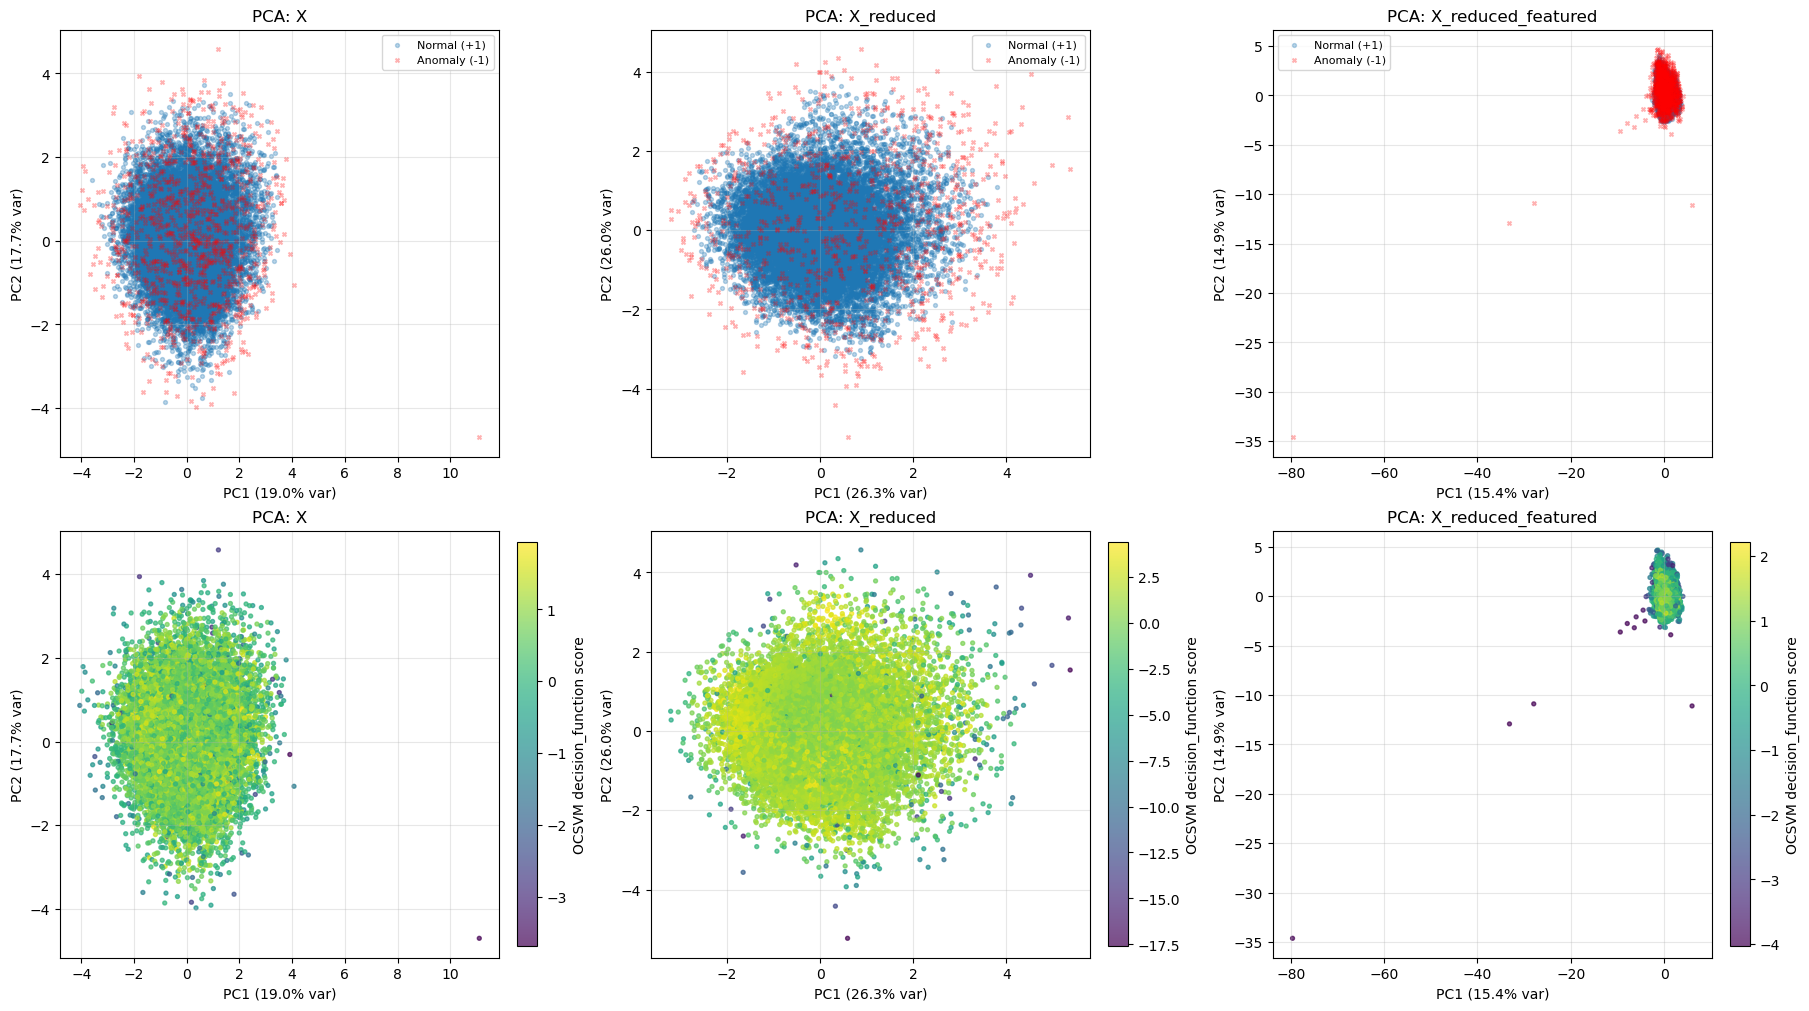

In [59]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True)

for col, ((key, x), (_, y)) in enumerate(zip(X_lib.items(), y_pred_lib.items())):
    if col >= 3:
        break

    X_data = x[1]
    labels = y[0]
    scores = y[1]

    # Row 1: anomaly labels
    plot_pca_anomalies(
        X_data=X_data,
        X_key=key,
        anomaly_labels=labels,
        ax=axes[0, col]
    )

    # Row 2: decision scores
    plot_pca_anomalies(
        X_data=X_data,
        X_key=key,
        anomaly_labels=labels,
        decision_scores=scores,
        ax=axes[1, col],
        add_colorbar=True
    )

plt.show()

Principal Component Analysis (PCA) is a linear dimensionality-reduction technique that projects high-dimensional data onto orthogonal axes (principal components) that maximise variance. Unlike UMAP, PCA does not preserve non-linear neighbourhood structure, but instead reveals how variance is distributed across linear combinations of features. As such, PCA is particularly useful for assessing whether anomalies correspond to directions of unusually large variance and for understanding how feature engineering reshapes the geometry of the data.

A higher performing anomaly model, when viewed through PCA, will exhibit the following characteristics:

Binary Anomaly Labels (Top Row)
	•	anomalies appearing preferentially at the periphery of the main cluster
	•	limited overlap between normal and anomalous points
	•	minimal contamination of the dense core by anomalies

Decision Function Continuous (Bottom Row)
	•	a clear gradient in decision function scores aligned with distance from the core
	•	low scores concentrated at extremes of principal components
	•	a stable, high-confidence inlier region near the centre

Original Feature Set (X)

Examining the PCA projection for the original scaled features, anomalies are heavily interspersed throughout the dense central region of the data cloud. The binary plot shows significant overlap between normal and anomalous points, with no clear separation along the first two principal components.

In the decision-function plot, scores vary weakly across the projection and do not align strongly with distance from the centre. This indicates that the dominant variance directions captured by PCA are not well aligned with the anomaly structure learned by the OCSVM. Anomalies in this representation are therefore subtle, local deviations rather than distinct operating regimes.

⸻

Reduced Feature Set (X_reduced)

The PCA projection of the reduced feature set shows a more compact and symmetric data cloud, with principal components explaining a higher proportion of variance. In the binary plot, anomalies are more frequently observed towards the outer regions of the cluster, though overlap with the core remains.

The decision-function plot exhibits a smoother gradient compared to the original feature set, with a clearer distinction between high-confidence inliers near the centre and lower-score points towards the edges. This improvement reflects the removal of redundant and colinear features, allowing PCA and the OCSVM to align more closely with meaningful structure in the data.

⸻

Physics-Informed Feature Set (X_reduced_featured)

The PCA projection of the physics-informed, residual-based feature set exhibits a markedly different structure. Normal operating states collapse into a tight, high-density cluster, while anomalous observations appear far from the core along the principal component axes.

This behaviour arises because residual-based features encode violations of learned physical relationships, which introduce high variance specifically for anomalous points. As PCA maximises variance, these violations dominate the principal components, resulting in strong spatial separation.

The binary plot shows minimal contamination of the dense core by anomalies, and the decision-function plot demonstrates a clear gradient, with the lowest scores located at the most extreme projections. This indicates strong alignment between variance structure, physical inconsistency, and anomaly detection.

In [74]:
# Parameters to try with the isolation forest

param_grid = [
    {"contamination": 0.02, "n_estimators": 300, "max_samples": 256, "max_features": 1.0},
    {"contamination": 0.03, "n_estimators": 300, "max_samples": 256, "max_features": 1.0},
    {"contamination": 0.04, "n_estimators": 300, "max_samples": 256, "max_features": 1.0},
    {"contamination": 0.05, "n_estimators": 300, "max_samples": 256, "max_features": 1.0},
    {"contamination": 0.02, "n_estimators": 500, "max_samples": 512, "max_features": 1.0},
    {"contamination": 0.03, "n_estimators": 500, "max_samples": 512, "max_features": 1.0},
    {"contamination": 0.04, "n_estimators": 500, "max_samples": 512, "max_features": 1.0},
    {"contamination": 0.05, "n_estimators": 500, "max_samples": 512, "max_features": 1.0},
]

In [75]:
# Loop to try each parameter set with each X_scaled dataset and store in a results library

from sklearn.ensemble import IsolationForest

tree_results = {}

for key, x in X_lib.items():
    X_data = x[0]
    columns = x[2]

    tree_results[key] = []

    for param in param_grid:
        iso_forest = IsolationForest(**param, random_state=42)
        iso_forest.fit(X_data)

        y_pred = iso_forest.predict(X_data)
        scores = iso_forest.decision_function(X_data)

        df_out = pd.DataFrame(X_data, columns=columns)
        df_out["anomaly"] = y_pred
        df_out["score"] = scores

        anomalies = df_out[df_out["anomaly"] == -1]

        tree_results[key].append({
            "params": param,
            "y_pred": y_pred,
            "scores": scores,
            "df": df_out,
            "anomalies": anomalies
        })
        
        # Seperation metric to evaluate each model and feature set
        sep = (
            scores[y_pred ==1].mean() - scores[y_pred == -1].mean()
        ) / scores.std()

        print(
            f"[IF] {key} | {param} → "
            f"{anomalies.shape[0]} anomalies "
            f"({anomalies.shape[0] / len(X_data):.2%})"
            f'separation {sep:.2f}'
        )

[IF] X | {'contamination': 0.02, 'n_estimators': 300, 'max_samples': 256, 'max_features': 1.0} → 391 anomalies (2.00%)separation 3.00
[IF] X | {'contamination': 0.03, 'n_estimators': 300, 'max_samples': 256, 'max_features': 1.0} → 587 anomalies (3.00%)separation 2.82
[IF] X | {'contamination': 0.04, 'n_estimators': 300, 'max_samples': 256, 'max_features': 1.0} → 782 anomalies (4.00%)separation 2.70
[IF] X | {'contamination': 0.05, 'n_estimators': 300, 'max_samples': 256, 'max_features': 1.0} → 977 anomalies (5.00%)separation 2.60
[IF] X | {'contamination': 0.02, 'n_estimators': 500, 'max_samples': 512, 'max_features': 1.0} → 391 anomalies (2.00%)separation 3.10
[IF] X | {'contamination': 0.03, 'n_estimators': 500, 'max_samples': 512, 'max_features': 1.0} → 587 anomalies (3.00%)separation 2.91
[IF] X | {'contamination': 0.04, 'n_estimators': 500, 'max_samples': 512, 'max_features': 1.0} → 782 anomalies (4.00%)separation 2.77
[IF] X | {'contamination': 0.05, 'n_estimators': 500, 'max_sam

If we examine the mean seperation distance of each configuration and each feature set, the combonation witht he highest separation is confgiuration 5 with X_reduced_features (mean separation 3.40), very closely followed by configuration 5 with X_reduced_features (3.34). In all three feature sets, the best performing based on the mean seperation distance is configuration 5. therefore lets proceed with plotting only for the first configuation.

In [77]:
tree_results['X']



[{'params': {'contamination': 0.02,
   'n_estimators': 300,
   'max_samples': 256,
   'max_features': 1.0},
  'y_pred': array([1, 1, 1, ..., 1, 1, 1]),
  'scores': array([0.14096505, 0.00090442, 0.04750075, ..., 0.06344329, 0.13675039,
         0.15613237]),
  'df':        engine_rpm  oil_pressure  fuel_pressure  coolant_pressure   oil_temp  \
  0           682.0      2.391656       4.617196          2.848982  76.272417   
  1           605.0      5.466877       6.424361          5.727520  73.222679   
  2           658.0      3.434232       3.680896          1.678708  88.089916   
  3           749.0      2.094656       7.120927          1.639670  77.661625   
  4           676.0      3.538228       5.956472          3.225336  75.226352   
  ...           ...           ...            ...               ...        ...   
  19530       681.0      3.598792       7.300853          1.083391  76.206955   
  19531       580.0      2.243040       5.242489          1.471350  76.884907   
  1953

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True)

for col, ((key, x), (_, y)) in enumerate(zip(X_lib.items(), tree_results.items())):
    if col >= 3:
        break  # only fill 3 columns

    X_data = x[1]
    y_pred = y[0]
    scores = y[1]

    plot_umap_anomalies(
        X_data, y_pred=y_pred,
        title='UMAP: IsolationTree anomalies found using ' + key,
        ax=axes[0, col]
    )

    plot_umap_anomalies(
        X_data, decision_scores=scores,
        title='UMAP: IsolationTree decision_function scores using ' + key,
        ax=axes[1, col],
        add_colorbar=True
    )

plt.show()

# Reflect

Write a brief paragraph highlighting your process and the rationale to showcase critical thinking and problem-solving.

> Select the pen from the toolbar to add your entry.

### Reference:
Devabrat, M., 2022. Predictive Maintenance on Ship's Main Engine using AI. Available at: https://dx.doi.org/10.21227/g3za-v415. [Accessed 5 March 2024]